In [1]:
import torch
import torch.nn as nn

import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer

from tqdm import tqdm

import json

from sklearn.manifold import TSNE

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/adi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/adi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
tokenizer = RegexpTokenizer(r'\w+')

In [6]:
review_text = []
start = 0
stop = 1000
for line in tqdm(open('Electronics_5.json', 'r')):
    rt = json.loads(line)['reviewText']
    clean_rt = [w.lower() for w in tokenizer.tokenize(rt) if ((w.lower() not in stop_words) and (w.isalpha()))]
    review_text.append(clean_rt)
    start+=1
    if start==stop:
        break

999it [00:00, 11991.34it/s]


In [7]:
freq_dict = dict()

for line in tqdm(review_text):
#     rt = json.loads(line)['reviewText']
#     clean_rt = [w.lower() for w in tokenizer.tokenize(rt) if ((not w.lower() in stop_words) and (w.isalpha()))]
    for word in line:
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word]+= 1

100%|██████████| 1000/1000 [00:00<00:00, 31142.28it/s]


In [8]:
#Find all words with less freq
kill_less = 2
remove_keys = set()
for key, value in freq_dict.items():
    if value<kill_less:
        remove_keys.add(key)

In [9]:
#Remove all words with less freq
for key in remove_keys:
    resp = freq_dict.pop(key, None)
    if resp is None:
        print("Logical Error")

In [10]:
#Setting Index Dict
counter = 1
index_dict = dict()
index_dict["PAD"] = 0
for key in freq_dict.keys():
    index_dict[key] = counter
    counter+=1

In [11]:
vocab_size = len(index_dict)

In [12]:
#Setting Word Dict
word_dict = dict()
word_dict[0] = "PAD"
for key, value in index_dict.items():
    word_dict[value] = key    

In [13]:
#Corpus is basically tokenized documents after removing all the stop words and the low frequency words
corpus = [[w for w in review if w in index_dict] for review in review_text]

In [14]:
CONTEXT_SIZE = 2  # 2 left, 2 right
EMDEDDING_DIM = 200

In [15]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.ReLU()
        

    def forward(self, inputs):
        embeds = torch.mean(self.embeddings(inputs),0).view(1,-1)
        return self.activation_function(self.linear(embeds))


model = CBOW(vocab_size, EMDEDDING_DIM)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [16]:
def context_target_pairs(document,window_size):
    ret = []
    context_length = window_size*2
    sentence_length = len(document)
    for index, word in enumerate(document):
        context_words = []
        target_word   = index_dict[word]       
        start = max(0,index - window_size)
        end = min(index + window_size + 1, sentence_length)
        context_words = [index_dict[document[i]] for i in range(start, end) if i != index]
        context_words = add_padding(context_words,context_length)
        ret.append((context_words,target_word))
    return ret

In [17]:
def add_padding(context,max_len):
    if max_len < len(context):
        
        raise Exception("max_len should be greater than vector length for vector : ",context,len(context),max_len)
    else:
        return [0]*(max_len-len(context)) + list(context)

In [18]:
data = []
for document in tqdm(corpus):
    data = data + context_target_pairs(document,CONTEXT_SIZE)

100%|██████████| 1000/1000 [00:00<00:00, 1230.07it/s]


In [25]:
for epoch in range(25):
    total_loss = 0

    for context, target in tqdm(data):
        context_vector = torch.tensor(context, dtype=torch.long) 
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([target]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    #Below TQDM log doesnt containg the time taken by back prop and optimizer

100%|██████████| 69033/69033 [00:11<00:00, 5885.97it/s]


In [41]:
#Saving and Loading Model
torch.save(model, "cbow.pt")
# model = torch.load("cbow.pt")

In [42]:
def word2embedding(word,model):
    if word in index_dict:
        return model.embeddings(torch.tensor([index_dict[word]]))
    else:
        None

In [43]:
# Camera
word2embedding('camera',model)

tensor([[-0.7715,  3.8001, -0.4787,  0.9449,  4.3423, -0.1094,  2.8796,  2.2602,
         -2.0534, -1.5612,  1.4866, -3.1562, -2.0136, -0.5811, -0.5937, -1.1012,
         -0.7432, -0.9380, -0.5945, -0.4228,  1.3750,  1.8837,  2.1810,  1.3604,
          0.6540,  1.1288,  1.2732,  0.9343,  2.0863,  2.2703, -0.6302,  1.8748,
          2.0705,  0.9632, -0.2557, -3.7779,  0.6180, -0.4570, -2.0739, -1.8672,
         -0.6640,  3.5088, -0.9398,  2.3164,  0.9954, -0.2409,  0.6435, -0.9655,
         -1.4811,  0.0701, -2.3120, -3.0452,  1.1439,  1.3609,  1.3069,  0.9129,
         -2.0742, -2.1247,  1.0430, -0.1396,  2.0452,  0.6596, -0.9013,  2.8900,
         -0.2546,  0.0789, -1.2916,  0.2081, -0.7458,  1.3914,  3.8688, -1.0413,
         -3.8855,  1.0704, -0.7679,  0.2315, -0.2340, -2.1583,  0.7781,  3.1014,
         -2.5271, -0.6516,  4.7489, -1.2232, -4.1381, -0.3378,  2.7871,  0.3990,
         -2.2596, -0.8772, -1.0335, -0.5549, -1.6134, -0.1195,  0.6940,  1.4804,
          1.0487,  1.7488,  

In [44]:
embedds = list(model.embeddings.parameters())[0].detach().cpu()

In [45]:
def find_top_10(word,embeddings):
    if word not in index_dict:
        return None
    else:
        i = index_dict[word]
        ans = []
        for j in range(len(embedds)):
            similarity = torch.cosine_similarity(embedds[i].view(1,-1), embedds[j].view(1,-1)).item()
            ans.append(similarity)
        top_10 = np.flip(np.argsort(ans)[-10:])
        for index in top_10:
            print(word_dict[index])           

In [46]:
find_top_10('camera',embedds)

camera
tablet
PAD
nook
great
one
reading
color
use
touch


In [47]:
words = ['camera','huge', 'big','mobile','play', 'fast','beautiful']
selected = [word2embedding(word,model).detach().numpy() for word in words]

In [48]:
selected = np.array(selected)
selected = selected.reshape(7,200)

In [49]:
X_embedded = TSNE(n_components=2).fit_transform(selected)

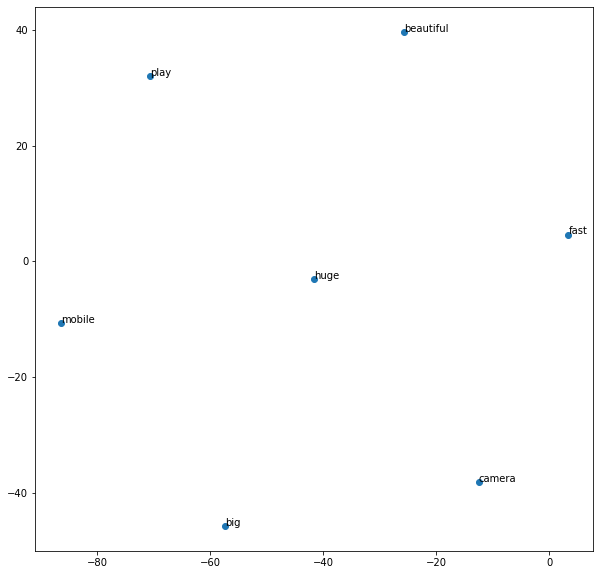

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
for word, (x,y) in zip(words, X_embedded):
    plt.text(x+0.05, y+0.05, word)
plt.show()